In [1]:
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer.reparam import TransformReparam, LocScaleReparam
from numpyro.distributions.transforms import AffineTransform
from numpyro.infer import MCMC, NUTS, Predictive, SVI, Trace_ELBO, log_likelihood
from numpyro.infer.autoguide import AutoLaplaceApproximation
import numpyro.optim as optim
from numpyro import handlers
from numpyro.handlers import mask
import jax
from jax.numpy import DeviceArray
import jax.numpy as jnp
from jax import random, lax
from jax import nn as jnn
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '
/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/jax/experimental/stax.py:28: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  warnings.warn('jax.experimental.stax is deprecated, '


In [177]:
d = pd.read_csv('data/tulips.csv', sep=';')

In [179]:
d.sample(5)

,bed,water,shade,blooms
1,a,1,2,0.00
0,a,1,1,0.00
18,c,1,1,10.02
8,a,3,3,134.95
10,b,1,2,85.95


In [180]:
d.describe()

,water,shade,blooms
count,27.00000,27.00000,27.000000
mean,2.00000,2.00000,128.993704
std,0.83205,0.83205,92.683923
min,1.00000,1.00000,0.000000
25%,1.00000,1.00000,71.115000
50%,2.00000,2.00000,111.040000
75%,3.00000,3.00000,190.300000
max,3.00000,3.00000,361.660000


In [181]:
d['W'] = d['water'] - 2
d['S'] = d['shade'] - 2
d['B'] = d['blooms'] / max(d['blooms'])

In [ ]:
def model(w, s, b=None):

    a = numpyro.sample('a', dist.Normal(0,0.5))
    bw = numpyro.sample('bw', dist.Normal(0,0.5))
    bs = numpyro.sample('bs', dist.Normal(0,0.5))
    sigma = numpyro.sample('sigma', dist.Exponential(1))

    mu = a + bw*b + bs*s

    blooms = numpyro.sample('blooms', dist.Normal(mu, sigma), obs=b)



In [3]:
with numpyro.handlers.seed(rng_seed=71):
    # number of plants
    N = 100

    # simulate initial heights
    h0 = numpyro.sample("h0", dist.Normal(10, 2).expand([N]))

    # assign treatments and simulate fungus and growth
    treatment = jnp.repeat(jnp.arange(2), repeats=N // 2)
    fungus = numpyro.sample(
        "fungus", dist.Binomial(total_count=1, probs=(0.5 - treatment * 0.4))
    )
    h1 = h0 + numpyro.sample("diff", dist.Normal(5 - 3 * fungus))

    # compose a clean data frame
    d = pd.DataFrame({"h0": h0, "h1": h1, "treatment": treatment, "fungus": fungus})


def model(h0, h1):
    p = numpyro.sample("p", dist.LogNormal(0, 0.25))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = h0 * p
    numpyro.sample("h1", dist.Normal(mu, sigma), obs=h1)


m6_6 = AutoLaplaceApproximation(model)
svi = SVI(model, m6_6, optim.Adam(0.1), Trace_ELBO(), h0=d.h0.values, h1=d.h1.values)
svi_result = svi.run(random.PRNGKey(0), 1000)
p6_6 = svi_result.params


def model(treatment, fungus, h0, h1):
    a = numpyro.sample("a", dist.LogNormal(0, 0.2))
    bt = numpyro.sample("bt", dist.Normal(0, 0.5))
    bf = numpyro.sample("bf", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    p = a + bt * treatment + bf * fungus
    mu = h0 * p
    numpyro.sample("h1", dist.Normal(mu, sigma), obs=h1)


m6_7 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m6_7,
    optim.Adam(0.3),
    Trace_ELBO(),
    treatment=d.treatment.values,
    fungus=d.fungus.values,
    h0=d.h0.values,
    h1=d.h1.values,
)
svi_result = svi.run(random.PRNGKey(0), 1000)
p6_7 = svi_result.params


def model(treatment, h0, h1):
    a = numpyro.sample("a", dist.LogNormal(0, 0.2))
    bt = numpyro.sample("bt", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    p = a + bt * treatment
    mu = h0 * p
    numpyro.sample("h1", dist.Normal(mu, sigma), obs=h1)


m6_8 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m6_8,
    optim.Adam(1),
    Trace_ELBO(),
    treatment=d.treatment.values,
    h0=d.h0.values,
    h1=d.h1.values,
)
svi_result = svi.run(random.PRNGKey(0), 1000)
p6_8 = svi_result.params

post = m6_7.sample_posterior(random.PRNGKey(11), p6_7, (1000,))
logprob = log_likelihood(
    m6_7.model,
    post,
    treatment=d.treatment.values,
    fungus=d.fungus.values,
    h0=d.h0.values,
    h1=d.h1.values,
)
az6_7 = az.from_dict(sample_stats={"log_likelihood": logprob["h1"][None, ...]})
az.waic(az6_7, scale="deviance")

100%|██████████| 1000/1000 [00:01<00:00, 787.19it/s, init loss: 87469.1094, avg. loss [951-1000]: 198.4736]
/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/arviz/stats/stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 1000 by 100 log-likelihood matrix

              Estimate       SE
deviance_waic   337.37    11.85
p_waic            3.35        -

There has been a warning during the calculation. Please check the results.

In [23]:
post = m6_6.sample_posterior(random.PRNGKey(77), p6_6, (1000,))
logprob = log_likelihood(m6_6.model, post, h0=d.h0.values, h1=d.h1.values)
az6_6 = az.from_dict({}, log_likelihood={"h1": logprob["h1"][None, ...]})
post = m6_7.sample_posterior(random.PRNGKey(77), p6_7, (1000,))
logprob = log_likelihood(
    m6_7.model,
    post,
    treatment=d.treatment.values,
    fungus=d.fungus.values,
    h0=d.h0.values,
    h1=d.h1.values,
)
az6_7 = az.from_dict({}, log_likelihood={"h1": logprob["h1"][None, ...]})
post = m6_8.sample_posterior(random.PRNGKey(77), p6_8, (1000,))
logprob = log_likelihood(
    m6_8.model, post, treatment=d.treatment.values, h0=d.h0.values, h1=d.h1.values
)
az6_8 = az.from_dict({}, log_likelihood={"h1": logprob["h1"][None, ...]})
compare = az.compare({"m6.6 Intercept only": az6_6, "m6.7 Fungus and treatment": az6_7, "m6.8 Treatment": az6_8}, ic="waic", scale="deviance")
compare

/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/arviz/stats/stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/arviz/stats/stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m6.7 Fungus and treatment,0,337.238970,3.299736,0.000000,1.000000e+00,11.839218,0.000000,True,deviance
m6.8 Treatment,1,399.758470,3.089427,62.519501,3.129164e-13,14.941817,13.814438,True,deviance
m6.6 Intercept only,2,409.200764,1.712087,71.961795,0.000000e+00,12.402171,12.712522,False,deviance


<AxesSubplot:xlabel='Deviance'>

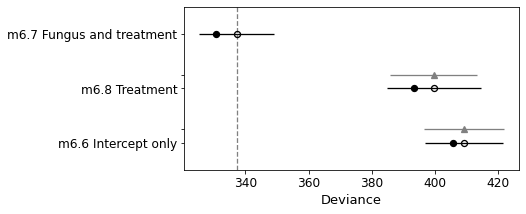

In [24]:
az.plot_compare(compare)

In [31]:
import math
- sum([0.3*math.log(0.3)+0.7*math.log(0.7)])

x = [0.2, 0.25, 0.35, 0.3]
entropy = 0
for p in x:
    entropy += p*math.log(p)
print(-entropy)


1.3970907576391107


### Chapter 7 Exercises

In [4]:
d = pd.read_csv('data/Laffer.csv', sep=';')
d.describe()

,tax_rate,tax_revenue
count,29.000000,29.000000
mean,26.382069,3.306207
std,8.753579,1.816491
min,0.070000,-0.060000
25%,22.370000,2.240000
50%,28.400000,3.070000
75%,33.250000,3.580000
max,35.430000,10.020000


<AxesSubplot:xlabel='tax_rate', ylabel='tax_revenue'>

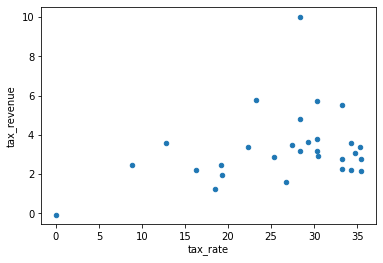

In [5]:
d.plot.scatter(x='tax_rate', y='tax_revenue')

In [41]:
scaler = StandardScaler()
d[['rate', 'revenue']] = scaler.fit_transform(d[['tax_rate', 'tax_revenue']])

In [42]:
def model(rate, revenue=None):
    a = numpyro.sample("a", dist.Normal(0, 1))
    b = numpyro.sample("b", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + b * rate)
    rev = numpyro.sample("rev", dist.Normal(mu, sigma), obs=revenue)

In [43]:
m1 = AutoLaplaceApproximation(model)
svi = SVI(model,m1,optim.Adam(1),Trace_ELBO())
svi_result = svi.run(random.PRNGKey(0), 1000, d['rate'].values, d['revenue'].values)
p1 = svi_result.params

# display summary of quadratic approximation
samples1 = m1.sample_posterior(random.PRNGKey(1), p1, (1000,))
numpyro.diagnostics.print_summary(samples1, group_by_chain=False)

100%|██████████| 1000/1000 [00:01<00:00, 899.93it/s, init loss: 608.8159, avg. loss [951-1000]: 42.4743]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.01      0.18      0.02     -0.28      0.30    931.50      1.00
         b      0.31      0.18      0.31      0.03      0.61   1111.41      1.00
     mu[0]     -0.93      0.57     -0.93     -1.79      0.03    911.49      1.00
     mu[1]     -0.62      0.40     -0.61     -1.27      0.02    887.85      1.00
     mu[2]     -0.47      0.33     -0.47     -1.03      0.03    877.58      1.00
     mu[3]     -0.35      0.27     -0.35     -0.83      0.05    873.19      1.00
     mu[4]     -0.25      0.23     -0.24     -0.66      0.09    893.49      1.00
     mu[5]     -0.24      0.23     -0.24     -0.65      0.09    895.07      1.00
     mu[6]     -0.27      0.24     -0.27     -0.71      0.06    884.85      1.00
     mu[7]      0.02      0.18      0.03     -0.27      0.31    931.08      1.00
     mu[8]     -0.13      0.19     -0.12     -0.46      0.18    965.98      1.00
     mu[9]     -0.03      0

In [44]:
x = jnp.linspace(-3.5, 2)

_predictive = Predictive(model=model, posterior_samples=samples1, guide=m1)
pred = _predictive(random.PRNGKey(2), x, None)

Text(0.5, 1.0, 'm1: Linear Gaussian')

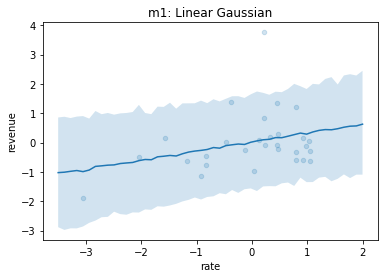

In [45]:
loc = pred['rev'].mean(axis=0)
low, high = jnp.percentile(pred['rev'], jnp.array([5.0, 95.0]), axis=0)
ax = d.plot.scatter('rate', 'revenue', alpha=0.2)
ax.plot(x, loc)
ax.fill_between(x, low, high, alpha = 0.2)
ax.set_title('m1: Linear Gaussian')

In [46]:
def model(rate, revenue=None):
    a = numpyro.sample("a", dist.Normal(0, 1))
    b1 = numpyro.sample("b1", dist.Normal(0, 1))
    b2 = numpyro.sample("b2", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + b1 * rate + b2 * rate**2)
    rev = numpyro.sample("rev", dist.Normal(mu, sigma), obs=revenue)

In [47]:
m2 = AutoLaplaceApproximation(model)
svi = SVI(model,m2,optim.Adam(1),Trace_ELBO())
svi_result = svi.run(random.PRNGKey(0), 1000, d['rate'].values, d['revenue'].values)
p2 = svi_result.params

# display summary of quadratic approximation
samples2 = m2.sample_posterior(random.PRNGKey(1), p2, (1000,))
numpyro.diagnostics.print_summary(samples2, group_by_chain=False)

100%|██████████| 1000/1000 [00:01<00:00, 767.83it/s, init loss: 4082.0554, avg. loss [951-1000]: 41.3206]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.20      0.20      0.19     -0.12      0.51   1049.96      1.00
        b1      0.06      0.23      0.06     -0.33      0.42    887.60      1.00
        b2     -0.21      0.13     -0.21     -0.44     -0.01   1039.79      1.00
     mu[0]     -1.93      0.80     -1.90     -3.14     -0.57   1063.33      1.00
     mu[1]     -0.78      0.38     -0.78     -1.48     -0.19    926.95      1.00
     mu[2]     -0.40      0.31     -0.39     -0.92      0.11    867.09      1.00
     mu[3]     -0.15      0.28     -0.14     -0.63      0.30    878.31      1.00
     mu[4]      0.01      0.27      0.02     -0.44      0.44    918.58      1.00
     mu[5]      0.02      0.27      0.02     -0.43      0.44    920.39      1.00
     mu[6]     -0.02      0.27     -0.02     -0.48      0.41    907.00      1.00
     mu[7]      0.21      0.20      0.20     -0.12      0.51   1054.45      1.00
     mu[8]      0.13      0

Text(0.5, 1.0, 'm2: Quadratic Gaussian')

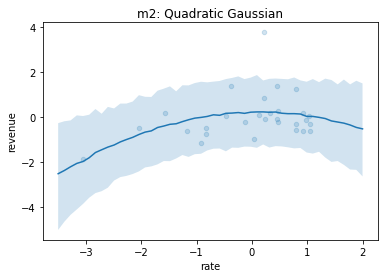

In [48]:
x = jnp.linspace(-3.5, 2)

_predictive = Predictive(model=model, posterior_samples=samples2, guide=m2)
pred = _predictive(random.PRNGKey(2), x, None)

loc = pred['rev'].mean(axis=0)
low, high = jnp.percentile(pred['rev'], jnp.array([5.0, 95.0]), axis=0)
ax = d.plot.scatter('rate', 'revenue', alpha=0.2)
ax.plot(x, loc)
ax.fill_between(x, low, high, alpha = 0.2)
ax.set_title('m2: Quadratic Gaussian')

In [49]:
def model(rate, revenue=None):
    a = numpyro.sample("a", dist.Normal(0, 1))
    b1 = numpyro.sample("b1", dist.Normal(0, 1))
    b2 = numpyro.sample("b2", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + b1 * rate + b2 * rate**2)
    rev = numpyro.sample("rev", dist.StudentT(2, mu, sigma), obs=revenue)

In [50]:
m3 = AutoLaplaceApproximation(model)
svi = SVI(model,m3,optim.Adam(1),Trace_ELBO())
svi_result = svi.run(random.PRNGKey(0), 1000, d['rate'].values, d['revenue'].values)
p3 = svi_result.params

# display summary of quadratic approximation
samples3 = m3.sample_posterior(random.PRNGKey(1), p3, (1000,))
numpyro.diagnostics.print_summary(samples3, group_by_chain=False)

100%|██████████| 1000/1000 [00:00<00:00, 1098.42it/s, init loss: 114.7598, avg. loss [951-1000]: 36.8676]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.00      0.23     -0.01     -0.38      0.36   1049.96      1.00
        b1     -0.09      0.16     -0.08     -0.37      0.16    893.98      1.00
        b2     -0.09      0.31     -0.09     -0.59      0.42   1130.32      1.00
     mu[0]     -0.58      2.62     -0.61     -4.78      3.53   1129.60      1.00
     mu[1]     -0.20      1.07     -0.21     -2.07      1.40   1117.73      1.00
     mu[2]     -0.09      0.58     -0.07     -1.01      0.89   1093.28      1.00
     mu[3]     -0.02      0.31     -0.02     -0.51      0.52    900.19      1.00
     mu[4]      0.01      0.22      0.02     -0.36      0.35    860.80      1.00
     mu[5]      0.01      0.21      0.02     -0.35      0.35    861.42      1.00
     mu[6]      0.01      0.23      0.01     -0.36      0.37    866.70      1.00
     mu[7]     -0.00      0.23     -0.01     -0.39      0.34   1052.33      1.00
     mu[8]      0.02      0

Text(0.5, 1.0, 'm3: Quadratic StudentT')

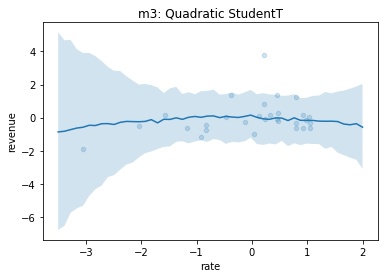

In [51]:
x = jnp.linspace(-3.5, 2)

_predictive = Predictive(model=model, posterior_samples=samples3, guide=m3)
pred = _predictive(random.PRNGKey(2), x, None)

loc = pred['rev'].mean(axis=0)
low, high = jnp.percentile(pred['rev'], jnp.array([5.0, 95.0]), axis=0)
ax = d.plot.scatter('rate', 'revenue', alpha=0.2)
ax.plot(x, loc)
ax.fill_between(x, low, high, alpha = 0.2)
ax.set_title('m3: Quadratic StudentT')

In [52]:
def model(rate, revenue=None):
    a = numpyro.sample("a", dist.Normal(0, 1))
    b = numpyro.sample("b", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + b * rate)
    rev = numpyro.sample("rev", dist.StudentT(2, mu, sigma), obs=revenue)

In [53]:
m4 = AutoLaplaceApproximation(model)
svi = SVI(model,m4,optim.Adam(1),Trace_ELBO())
svi_result = svi.run(random.PRNGKey(0), 1000, d['rate'].values, d['revenue'].values)
p4 = svi_result.params

# display summary of quadratic approximation
samples4 = m4.sample_posterior(random.PRNGKey(1), p4, (1000,))
numpyro.diagnostics.print_summary(samples4, group_by_chain=False)

100%|██████████| 1000/1000 [00:00<00:00, 1315.67it/s, init loss: 100.5423, avg. loss [951-1000]: 37.3432]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.26      0.11     -0.26     -0.45     -0.07    931.50      1.00
         b      0.19      0.13      0.19     -0.04      0.39    964.57      1.00
     mu[0]     -0.85      0.44     -0.85     -1.56     -0.13    890.10      1.00
     mu[1]     -0.66      0.31     -0.65     -1.18     -0.17    880.08      1.00
     mu[2]     -0.57      0.26     -0.56     -1.01     -0.18    873.20      1.00
     mu[3]     -0.49      0.21     -0.48     -0.85     -0.18    875.25      1.00
     mu[4]     -0.42      0.17     -0.42     -0.73     -0.17    895.52      1.00
     mu[5]     -0.42      0.17     -0.41     -0.72     -0.17    896.93      1.00
     mu[6]     -0.44      0.18     -0.43     -0.77     -0.18    887.66      1.00
     mu[7]     -0.25      0.11     -0.25     -0.44     -0.07    931.06      1.00
     mu[8]     -0.35      0.14     -0.34     -0.58     -0.13    968.48      1.00
     mu[9]     -0.28      0

Text(0.5, 1.0, 'm4: Linear StudentT')

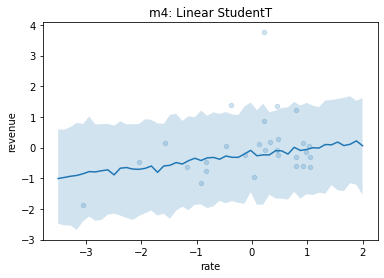

In [54]:
x = jnp.linspace(-3.5, 2)

_predictive = Predictive(model=model, posterior_samples=samples4, guide=m4)
pred = _predictive(random.PRNGKey(2), x, None)

loc = pred['rev'].mean(axis=0)
low, high = jnp.percentile(pred['rev'], jnp.array([5.0, 95.0]), axis=0)
ax = d.plot.scatter('rate', 'revenue', alpha=0.2)
ax.plot(x, loc)
ax.fill_between(x, low, high, alpha = 0.2)
ax.set_title('m4: Linear StudentT')

In [56]:
logprob1= log_likelihood(m1.model, samples1, d['rate'].values, d['revenue'].values)
az1 = az.from_dict({}, log_likelihood={"rev": logprob1["rev"][None, ...]})

logprob2= log_likelihood(m2.model, samples2, d['rate'].values, d['revenue'].values)
az2 = az.from_dict({}, log_likelihood={"rev": logprob2["rev"][None, ...]})

logprob3= log_likelihood(m3.model, samples3, d['rate'].values, d['revenue'].values)
az3 = az.from_dict({}, log_likelihood={"rev": logprob3["rev"][None, ...]})

logprob4= log_likelihood(m4.model, samples4, d['rate'].values, d['revenue'].values)
az4 = az.from_dict({}, log_likelihood={"rev": logprob4["rev"][None, ...]})

compare = az.compare({"m1 Linear gaussian": az1, "m2 Quadratic gaussian": az2, "m3 Quadratic StudentT": az3, "m4 Linear StudentT": az4}, ic="waic", scale="deviance")
compare

/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/arviz/stats/stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/arviz/stats/stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/arviz/stats/stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/a

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m4 Linear StudentT,0,75.278078,3.527785,0.000000,7.193656e-01,12.942151,0.000000,True,deviance
m2 Quadratic gaussian,1,88.578585,6.374949,13.300506,2.806344e-01,21.547813,13.882884,True,deviance
m1 Linear gaussian,2,90.605353,6.305949,15.327274,0.000000e+00,21.098658,13.269101,True,deviance
m3 Quadratic StudentT,3,93.125580,11.158882,17.847502,1.929568e-13,15.344470,8.335666,True,deviance


In [134]:
d = pd.read_csv('data/birds.txt')
d.set_index('island', inplace=True)
print(d.sum(axis = 1))
d

island
1    1.0
2    1.0
3    1.0
dtype: float64


,sp_A,sp_B,sp_C,sp_D,sp_E
island,,,,,
1,0.20,0.20,0.20,0.200,0.200
2,0.80,0.10,0.05,0.025,0.025
3,0.05,0.15,0.70,0.050,0.050


In [136]:
def entropy(p):
    return -np.sum(p * np.log(p))

In [138]:
d.apply(lambda island : entropy(island), axis = 1)

island
1    1.609438
2    0.743004
3    0.983600
dtype: float64

In [141]:
def LK_divergence(x):
    n_islands, n_species = x.shape
    KL_divergence = np.zeros((n_islands, n_islands))
    for from_island in range(n_islands):
        for to_island in range(n_islands):
            p = x[from_island,:]
            q = x[to_island,:]
            KL_divergence[from_island,to_island] = np.sum(p*(np.log(p) - np.log(q)))
    return KL_divergence

In [142]:
LK_divergence(d.values)

array([[0.        , 0.97040605, 0.63876044],
       [0.86643398, 0.        , 2.01091424],
       [0.62583761, 1.83884518, 0.        ]])

In [161]:
d = pd.read_csv('data/foxes.csv', sep=';')

In [162]:
d.sample(5)

,group,avgfood,groupsize,area,weight
57,18,1.21,8,5.07,3.99
48,16,0.72,4,3.54,4.25
47,15,0.73,4,2.65,2.01
46,15,0.73,4,2.65,5.37
0,1,0.37,2,1.09,5.02


In [163]:
d[['F', 'S', 'A', 'W']] = scaler.fit_transform(d[['avgfood', 'groupsize', 'area', 'weight']])
d.describe()

,group,avgfood,groupsize,area,weight,F,S,A,W
count,116.000000,116.000000,116.000000,116.000000,116.000000,1.160000e+02,1.160000e+02,1.160000e+02,1.160000e+02
mean,17.206897,0.751724,4.344828,3.169138,4.529655,3.100968e-16,-1.780185e-16,-5.933951e-16,4.153765e-16
std,8.002736,0.198316,1.538511,0.928354,1.184023,1.004338e+00,1.004338e+00,1.004338e+00,1.004338e+00
min,1.000000,0.370000,2.000000,1.090000,1.920000,-1.933180e+00,-1.530701e+00,-2.249313e+00,-2.213621e+00
25%,11.750000,0.660000,3.000000,2.590000,3.720000,-4.645220e-01,-8.779020e-01,-6.265396e-01,-6.867840e-01
50%,18.000000,0.735000,4.000000,3.130000,4.420000,-8.469668e-02,-2.251031e-01,-4.234132e-02,-9.301419e-02
75%,24.000000,0.800000,5.000000,3.772500,5.375000,2.444853e-01,4.276958e-01,6.527464e-01,7.170575e-01
max,30.000000,1.210000,8.000000,5.070000,7.550000,2.320864e+00,2.386093e+00,2.056445e+00,2.561985e+00


In [164]:
def model(F, S, A, W=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bf = numpyro.sample("bf", dist.Normal(0, 0.5))
    bs = numpyro.sample("bs", dist.Normal(0, 0.5))
    ba = numpyro.sample("ba", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    #mu = numpyro.deterministic("mu", a + bf*F + bs*S + ba*A)
    mu = a + bf*F + bs*S + ba*A
    weight = numpyro.sample("weight", dist.Normal(mu, sigma), obs=W)

In [165]:
m1 = AutoLaplaceApproximation(model)
svi = SVI(model,m1,optim.Adam(1),Trace_ELBO())
svi_result = svi.run(random.PRNGKey(0), 1000, d.F.values, d.S.values, d.A.values, d.W.values)
p1 = svi_result.params

# display summary of quadratic approximation
samples1 = m1.sample_posterior(random.PRNGKey(1), p1, (1000,))
numpyro.diagnostics.print_summary(samples1, group_by_chain=False)

100%|██████████| 1000/1000 [00:02<00:00, 474.74it/s, init loss: 334.7635, avg. loss [951-1000]: 159.4331]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.00      0.08      0.00     -0.14      0.12   1009.20      1.00
        ba      0.28      0.17      0.28      0.01      0.57    755.37      1.00
        bf      0.29      0.21      0.29     -0.08      0.61    998.97      1.00
        bs     -0.64      0.18     -0.64     -0.95     -0.37   1034.51      1.00
     sigma      0.94      0.06      0.94      0.84      1.04    847.92      1.00



In [166]:
def model(F, S, W=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bf = numpyro.sample("bf", dist.Normal(0, 0.5))
    bs = numpyro.sample("bs", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + bf*F + bs*S
    weight = numpyro.sample("weight", dist.Normal(mu, sigma), obs=W)

m2 = AutoLaplaceApproximation(model)
svi = SVI(model,m2,optim.Adam(1),Trace_ELBO())
svi_result = svi.run(random.PRNGKey(0), 1000, d.F.values, d.S.values, d.W.values)
p2 = svi_result.params

# display summary of quadratic approximation
samples2 = m2.sample_posterior(random.PRNGKey(1), p2, (1000,))
numpyro.diagnostics.print_summary(samples2, group_by_chain=False)

100%|██████████| 1000/1000 [00:01<00:00, 742.35it/s, init loss: 1578.7648, avg. loss [951-1000]: 160.5182]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.00      0.08     -0.01     -0.13      0.12   1049.96      1.00
        bf      0.48      0.18      0.48      0.17      0.78    822.38      1.00
        bs     -0.58      0.18     -0.58     -0.89     -0.31    836.43      1.00
     sigma      0.95      0.06      0.95      0.84      1.04    958.43      1.00



In [167]:
def model(S, A, W=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bs = numpyro.sample("bs", dist.Normal(0, 0.5))
    ba = numpyro.sample("ba", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + bs*S + ba*A
    weight = numpyro.sample("weight", dist.Normal(mu, sigma), obs=W)

m3 = AutoLaplaceApproximation(model)
svi = SVI(model,m3,optim.Adam(1),Trace_ELBO())
svi_result = svi.run(random.PRNGKey(0), 1000, d.S.values, d.A.values, d.W.values)
p3 = svi_result.params

# display summary of quadratic approximation
samples3 = m3.sample_posterior(random.PRNGKey(1), p3, (1000,))
numpyro.diagnostics.print_summary(samples3, group_by_chain=False)

100%|██████████| 1000/1000 [00:01<00:00, 754.72it/s, init loss: 3136.8354, avg. loss [951-1000]: 160.1867]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.00      0.08     -0.01     -0.13      0.12   1049.96      1.00
        ba      0.41      0.15      0.41      0.16      0.65    822.38      1.00
        bs     -0.48      0.14     -0.48     -0.72     -0.24    856.36      1.00
     sigma      0.95      0.06      0.95      0.85      1.04    960.71      1.00



In [168]:
def model(F, W=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bf = numpyro.sample("bf", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + bf*F
    weight = numpyro.sample("weight", dist.Normal(mu, sigma), obs=W)

m4 = AutoLaplaceApproximation(model)
svi = SVI(model,m4,optim.Adam(1),Trace_ELBO())
svi_result = svi.run(random.PRNGKey(0), 1000, d.F.values, d.W.values)
p4 = svi_result.params

# display summary of quadratic approximation
samples4 = m4.sample_posterior(random.PRNGKey(1), p4, (1000,))
numpyro.diagnostics.print_summary(samples4, group_by_chain=False)

100%|██████████| 1000/1000 [00:01<00:00, 997.65it/s, init loss: 3411.7129, avg. loss [951-1000]: 165.0971]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.01      0.09      0.01     -0.13      0.15    931.50      1.00
        bf     -0.03      0.09     -0.03     -0.17      0.14   1111.41      1.00
     sigma      1.00      0.07      1.00      0.90      1.13    949.31      1.00



In [169]:
def model(A, W=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    ba = numpyro.sample("ba", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + ba*A
    weight = numpyro.sample("weight", dist.Normal(mu, sigma), obs=W)

m5 = AutoLaplaceApproximation(model)
svi = SVI(model,m5,optim.Adam(1),Trace_ELBO())
svi_result = svi.run(random.PRNGKey(0), 1000, d.A.values, d.W.values)
p5 = svi_result.params

# display summary of quadratic approximation
samples5 = m5.sample_posterior(random.PRNGKey(1), p5, (1000,))
numpyro.diagnostics.print_summary(samples5, group_by_chain=False)

100%|██████████| 1000/1000 [00:01<00:00, 986.07it/s, init loss: 3284.0828, avg. loss [951-1000]: 165.1109]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.01      0.09      0.01     -0.13      0.15    931.50      1.00
        ba      0.02      0.09      0.02     -0.13      0.18   1111.41      1.00
     sigma      1.00      0.07      1.00      0.91      1.13    949.04      1.00



In [172]:
logprob1= log_likelihood(m1.model, samples1, d.F.values, d.S.values, d.A.values, d.W.values)
az1 = az.from_dict({}, log_likelihood={"weight": logprob1["weight"][None, ...]})

logprob2= log_likelihood(m2.model, samples2, d.F.values, d.S.values, d.W.values)
az2 = az.from_dict({}, log_likelihood={"weight": logprob2["weight"][None, ...]})

logprob3= log_likelihood(m3.model, samples3, d.S.values, d.A.values, d.W.values)
az3 = az.from_dict({}, log_likelihood={"weight": logprob3["weight"][None, ...]})

logprob4= log_likelihood(m4.model, samples4, d.F.values, d.W.values)
az4 = az.from_dict({}, log_likelihood={"weight": logprob4["weight"][None, ...]})

logprob5= log_likelihood(m5.model, samples5, d.A.values, d.W.values)
az5 = az.from_dict({}, log_likelihood={"weight": logprob5["weight"][None, ...]})

compare = az.compare({"m1 Food, groupsize, area": az1, "m2 Food, groupsize": az2, "m3 groupsize, area": az3, "m4 Food": az4, "m5 Area": az5}, ic="waic", scale="deviance")
compare

/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/arviz/stats/stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/pasbury/neg-price-model/venv/lib/python3.8/site-packages/arviz/stats/stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
"m1 Food, groupsize, area",0,324.355732,4.882306,0.000000,0.000000,16.299507,0.000000,True,deviance
"m2 Food, groupsize",1,324.671632,3.609371,0.315900,0.521596,15.865722,3.624160,False,deviance
"m3 groupsize, area",2,324.886821,3.726207,0.531088,0.478404,15.610412,2.943360,True,deviance
m4 Food,3,334.630024,2.493057,10.274292,0.000000,13.629199,7.272037,False,deviance
m5 Area,4,334.909465,2.721910,10.553733,0.000000,13.597167,7.327329,False,deviance


<AxesSubplot:xlabel='Deviance'>

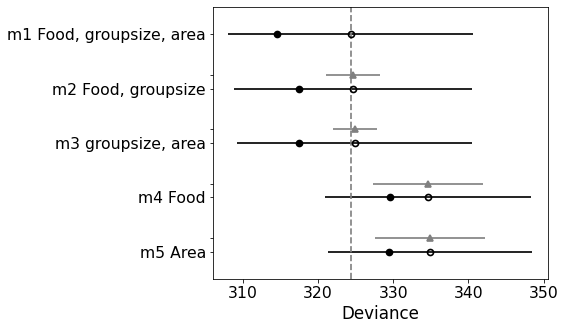

In [173]:
az.plot_compare(compare)